**Librerias**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
READ_DATA_PATH = os.getenv("INTERIM_DATA_PATH")
SAVE_DATA_PATH = os.getenv("TRAIN_PROCESSED_DATA_PATH")
ALL_DATA_PATH = os.getenv("ALL_PROCESSED_DATA_PATH")

**Cargar datos**

In [3]:
df =  pd.read_excel(f"../../{READ_DATA_PATH}")

**Eliminar columnas sobrantes**

In [4]:
columnsToDrop = ['FACULTAD', 'CARRERA', 'MATERIA', 'COD_GRUPO', 'GRUPO/PARALELO']

In [5]:
df.drop(columns=columnsToDrop, inplace=True)

**Incluir modulos de ingles dentro de los ciclos normales**

In [6]:
mapeo = {
    '2023 - 2024 ING2B': '2023 - 2024 CII',
    '2024 - 2025 ING1B': '2024 - 2025 CI',
    '2024 - 2025 ING2B': '2024 - 2025 CII',
    '2025 - 2026 ING1A': '2025 - 2026 CI',
    '2025 - 2026 ING1B': '2025 - 2026 CI',
    
    }

In [7]:
df['PERIODO']= df['PERIODO'].map(lambda x: mapeo.get(x, x))

**Agregación por Estudiante-Periodo**

In [8]:
agg = (
    df.groupby(["ESTUDIANTE", "PERIODO"])
      .agg(
          PROM_PERIODO=("PROMEDIO", "mean"),
          ASIST_PROM=("ASISTENCIA", "mean"),
          TOTAL_MAT=("COD_MATERIA", "count"),
          REPROBADAS=("ESTADO", lambda x: (x == "REPROBADA").sum()),
          REPITENCIAS=("NO. VEZ", lambda x: (x >= 2).sum()),
          NIVEL=("NIVEL", "max")
      )
      .reset_index()
)

In [9]:
agg["PROP_REPROB"] = agg["REPROBADAS"] / agg["TOTAL_MAT"]

**Definir la variable objetivo**


Un estudiante está en riesgo si cumple ≥ N criterios de riesgo
- `RIESGO_DESERCION = 1` si el estudiante cumple al menos 3 criterios de riesgo
- `RIESGO_DESERCION = 0` sin riesgo de deserción

In [10]:
agg["RIESGO_SCORE"] = (
    (agg["PROP_REPROB"] >= 0.4).astype(int) +
    (agg["ASIST_PROM"] < 70).astype(int) +
    (agg["PROM_PERIODO"] < 7).astype(int) +
    (agg["REPITENCIAS"] >= 2).astype(int) +
    (agg["NIVEL"] <= 3).astype(int)
)

agg["RIESGO_t"] = (agg["RIESGO_SCORE"] >= 3).astype(int)

In [11]:
agg = agg.sort_values(["PERIODO"])
agg["RIESGO_t1"] = agg.groupby("ESTUDIANTE")["RIESGO_t"].shift(-1)

La variable objetivo fue desplazada temporalmente al período académico siguiente (t+1), permitiendo entrenar modelos predictivos que utilizan únicamente información disponible en el período actual, evitando sesgos por fuga de información y simulando un escenario real de toma de decisiones.

In [12]:
train_dataset = agg.dropna(subset=["RIESGO_t1"]).copy()
train_dataset["RIESGO_t1"] = train_dataset["RIESGO_t1"].astype(int)
train_dataset["RIESGO_t1"].value_counts(normalize=True) * 100

RIESGO_t1
0    85.060976
1    14.939024
Name: proportion, dtype: float64

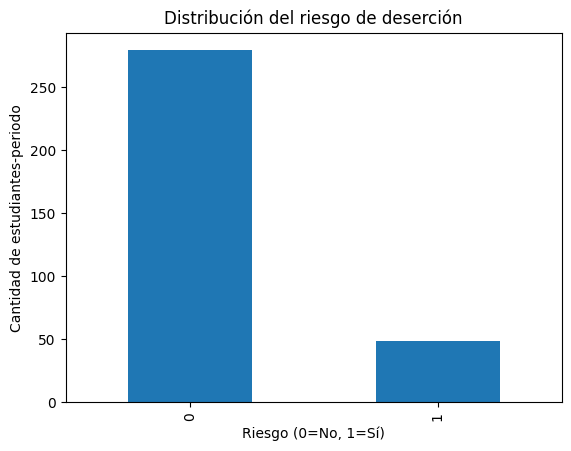

In [13]:
plt.figure()
train_dataset["RIESGO_t1"].value_counts().plot(kind="bar")
plt.title("Distribución del riesgo de deserción")
plt.xlabel("Riesgo (0=No, 1=Sí)")
plt.ylabel("Cantidad de estudiantes-periodo")
plt.show()

El conjunto de datos fue transformado a una estructura temporal estudiante–período, permitiendo definir una variable objetivo dinámica que representa el riesgo de deserción en el período siguiente, evitando el uso de información futura y garantizando consistencia temporal.

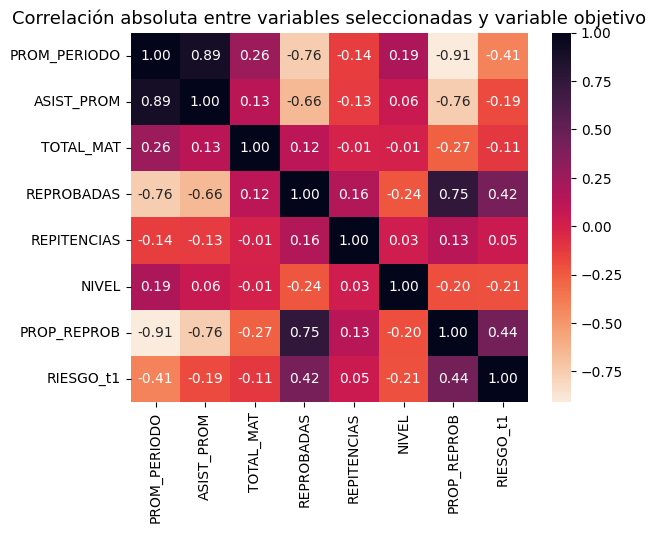

In [14]:
corr = agg[['PROM_PERIODO', 'ASIST_PROM', 'TOTAL_MAT',
           'REPROBADAS', 'REPITENCIAS', 'NIVEL',
           'PROP_REPROB','RIESGO_t1']].corr()
sns.heatmap(corr, cmap="rocket_r", annot=True, fmt=".2f")
plt.title("Correlación absoluta entre variables seleccionadas y variable objetivo", fontsize=13)
plt.show()

In [15]:
agg.to_excel(f"../../{ALL_DATA_PATH}", index=False)

In [16]:
# Guardar datos listos para el entrenamiento del modelo
train_dataset.to_excel(f"../../{SAVE_DATA_PATH}", index=False)

In [139]:
# Guardar datos para test cuando se tenga el proximo periodo
test_dataset = agg[agg["RIESGO_t1"].isna()]